# Домашняя работа 4 #

In [121]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [122]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_samples=10000, n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5, flip_y=0.03)

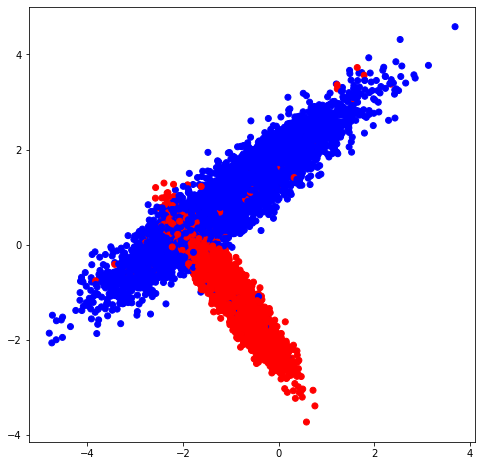

In [123]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [124]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [125]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [126]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [127]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

**1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.).**

**2. Для задачи классификации обучить дерево решений с использованием критериев разбиения Джини и Энтропия. Сравнить качество классификации, сделать выводы.**

In [142]:
class Tree:

    def __init__(self, max_depth=10, max_leaves=30, quality_criteria="Gini"):
        self.max_depth = max_depth
        self.nodes = []
        self.leaves = []
        self.depth = 0
        self.max_leaves = max_leaves
        self.quality_criteria = quality_criteria
        self.tree = None

    def gini(self, labels):  # Расчет критерия Джини
        #  подсчет количества объектов разных классов
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        #  расчет критерия
        impurity = 1
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p ** 2

        return impurity

    def entropy(self, labels):  # Расчет энтропии
        #  подсчет количества объектов разных классов
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        #  расчет критерия
        entropy = 0
        for label in classes:
            p = classes[label] / len(labels)
            entropy -= p * np.log2(p)

        return entropy

    def quality_gini(self, left_labels, right_labels, current_gini):  # Расчет качества по Джани

        # доля выбоки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

        return current_gini - p * self.gini(left_labels) - (1 - p) * self.gini(right_labels)

    def quality_entropy(self, left_labels, right_labels, current_entropy):  # Расчет качества по Энтропии

        # доля выбоки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

        return current_entropy - p * self.entropy(left_labels) - (1 - p) * self.entropy(right_labels)

    def split(self, data, labels, index, t):  # Разбиение датасета в узле

        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels

    def find_best_split(self, data, labels):  # Нахождение наилучшего разбиения

        #  обозначим минимальное количество объектов в узле
        min_leaf = 10
        #  Определим используемую функцию качества и начальную метрику качества

        if self.quality_criteria == "Entropy":
            current_quality_metric = self.entropy(labels)
            quality_function = self.quality_entropy
        else:
            current_quality_metric = self.gini(labels)
            quality_function = self.quality_gini
        
        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            t_values = [row[index] for row in data]

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 10 объектов
                if len(true_data) < min_leaf or len(false_data) < min_leaf:
                    continue

                current_quality = quality_function(true_labels, false_labels, current_quality_metric)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index

    def build_tree(self, data, labels):

        quality, t, index = self.find_best_split(data, labels)


        # прекращаем рекурсию, когда достигнуто максимальное количество листьев
        if len(self.leaves) >= self.max_leaves - 1:
            self.leaves.append(Leaf(data, labels))
            return Leaf(data, labels)

        # прекращаем рекурсию, когда достигнута максимальная глубина дерева
        if self.depth >= self.max_depth:
            self.leaves.append(Leaf(data, labels))
            return Leaf(data, labels)

        self.depth += 1

        #  прекращаем рекурсию, когда нет прироста в качества
        if quality == 0:
            self.leaves.append(Leaf(data, labels))
            return Leaf(data, labels)

        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels)
        false_branch = self.build_tree(false_data, false_labels)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        self.nodes.append(Node(index, t, true_branch, false_branch))
        return Node(index, t, true_branch, false_branch)

    def classify_object(self, obj, node):

        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)

    def fit(self, data, labels):
        self.tree = self.build_tree(data, labels)
        return self

    def predict(self, data):

        classes = []
        for obj in data:
            prediction = self.classify_object(obj, self.tree)
            classes.append(prediction)

        return classes


In [143]:
# Построим дерево по обучающей выборке (критерий Джини)
my_tree_gini = Tree()
my_tree_gini.fit(train_data, train_labels)

In [144]:
print_tree(my_tree_gini.tree)

Индекс 1
Порог 0.040856302117733945
--> True:
  Индекс 0
  Порог -1.9126751813469252
  --> True:
    Индекс 0
    Порог -2.067487020468966
    --> True:
      Индекс 1
      Порог 0.028176038132262327
      --> True:
        Индекс 1
        Порог -0.8345518275912711
        --> True:
          Прогноз: 1
        --> False:
          Индекс 1
          Порог -0.7601910389652748
          --> True:
            Прогноз: 1
          --> False:
            Индекс 0
            Порог -2.6130585556002304
            --> True:
              Индекс 0
              Порог -2.6391649103989625
              --> True:
                Прогноз: 1
              --> False:
                Прогноз: 1
            --> False:
              Прогноз: 1
      --> False:
        Прогноз: 1
    --> False:
      Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


In [145]:
# Построим дерево по обучающей выборке (критерий энтропии)
my_tree_entropy = Tree(quality_criteria="Entropy")
my_tree_entropy.fit(train_data, train_labels)

In [146]:
print_tree(my_tree_entropy.tree)

Индекс 1
Порог 0.040856302117733945
--> True:
  Индекс 0
  Порог -1.9126751813469252
  --> True:
    Индекс 0
    Порог -2.1182657887348224
    --> True:
      Индекс 0
      Порог -2.3976343426489466
      --> True:
        Индекс 1
        Порог -0.8345518275912711
        --> True:
          Прогноз: 1
        --> False:
          Индекс 0
          Порог -2.6130585556002304
          --> True:
            Индекс 0
            Порог -2.6391649103989625
            --> True:
              Индекс 0
              Порог -2.695580261862612
              --> True:
                Индекс 0
                Порог -2.723632401296423
                --> True:
                  Прогноз: 1
                --> False:
                  Прогноз: 1
              --> False:
                Прогноз: 1
            --> False:
              Прогноз: 1
          --> False:
            Прогноз: 1
      --> False:
        Прогноз: 1
    --> False:
      Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Пр

In [147]:
# Получим ответы для обучающей выборки (Джини)
train_answers_gini = my_tree_gini.predict(train_data)
# Получим ответы для обучающей выборки (Энтропия)
train_answers_entropy =my_tree_entropy.predict(train_data)
# Получим ответы для тестовой выборки для деревьев
answers_gini = my_tree_gini.predict(test_data)
answers_entropy = my_tree_entropy.predict(test_data)

In [148]:
train_accuracy_gini = accuracy_metric(train_labels, train_answers_gini)
train_accuracy_entropy = accuracy_metric(train_labels, train_answers_entropy)
print (f'Точность на обучающей выборке для Джини: {train_accuracy_gini}, для Энтропии: {train_accuracy_entropy}')

Точность на обучающей выборке для Джини: 94.38571428571429, для Энтропии: 94.38571428571429


In [149]:
# Точность на тестовой выборке
test_accuracy_gini = accuracy_metric(test_labels, answers_gini)
test_accuracy_entropy = accuracy_metric(test_labels, answers_entropy)
print (f'Точность на тестовой выборке для Джини: {test_accuracy_gini}, для Энтропии: {test_accuracy_entropy}')

Точность на тестовой выборке для Джини: 93.56666666666666, для Энтропии: 93.56666666666666
